### **_Hypothesis_4**:  
   The rating score is influenced by individual users, whose unique personalities and personal preferences may lead them to either overestimate or underestimate a book's quality. In addition, the Anonymous tends to overrate the books

   - **Metric**: Rating score

- **Missing Values**:

  - `profileName`: Missing values are set as "Anonymous"
  - `review/score`: The entire sample is removed.



- **Hypotheses**:
  - **H0**: The rating score is not related to the `profileName`, as all rating scores originate from the same distribution. If we consider the rating score of each user, they have the same mean and variance.

  - **H1**: The rating score is affected by the user, meaning the rating scores of each user follow a different distribution.

For the sake of consistency in this analysis, users with fewer than 20 reviews are excluded. This is because a lower number of reviews is insufficient to significantly estimate statistical measures.


In [78]:
# Import libraries

import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ks_2samp
import scipy_analyze as sa

In [79]:
# Connect to MongoDB

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_joined']

### Get data from MongoDB


In [80]:
# Define the aggregation pipeline
pipeline = [
    {
        "$project": {
            "profileName": {
                "$ifNull": ["$profileName", "Anonymous"]
            },
            "review/score": 1
        }
    },
    {'$match': {
        'review/score': {'$exists': True, '$ne': 0.0},
    }
    }
]

# Execute the aggregation query and create a DataFrame
source_df = pd.DataFrame(list(books.aggregate(pipeline)))
source_df = source_df.drop('_id', axis=1)

### Prepare the DataFrame for the analysis


In [81]:
user_stats = source_df.groupby('profileName').mean()


user_stats['Std_review_score'] = source_df.groupby('profileName').std()
user_stats['N_reviews'] = source_df['profileName'].value_counts()
user_stats = user_stats.sort_values(by='review/score', ascending=False)
user_stats.reset_index(inplace=True)
user_stats = user_stats[user_stats['profileName'] != 'Anonymous']

user_stats.columns = ['profileName',
                      'Mean_review/score', 'Std_review_score', 'N_reviews']

user_stats = user_stats[user_stats['N_reviews'] >= 20]
user_stats = user_stats.sort_values(by='Std_review_score', ascending=False)
user_stats

,profileName,Mean_review/score,Std_review_score,N_reviews
128039,Caraculiambro,3.107143,1.728611,28
127544,Patrick,3.384615,1.722253,26
126125,A Reader,3.604938,1.633088,81
126195,Tim,3.585366,1.627507,41
125098,Reviewer,3.840000,1.624808,25
...,...,...,...,...
51644,michaelle,5.000000,0.000000,32
47797,Michael Battaglia,5.000000,0.000000,34
136229,K. E. Hawes,3.000000,0.000000,20
43302,Midwest Book Review,5.000000,0.000000,591


### Visualize the data

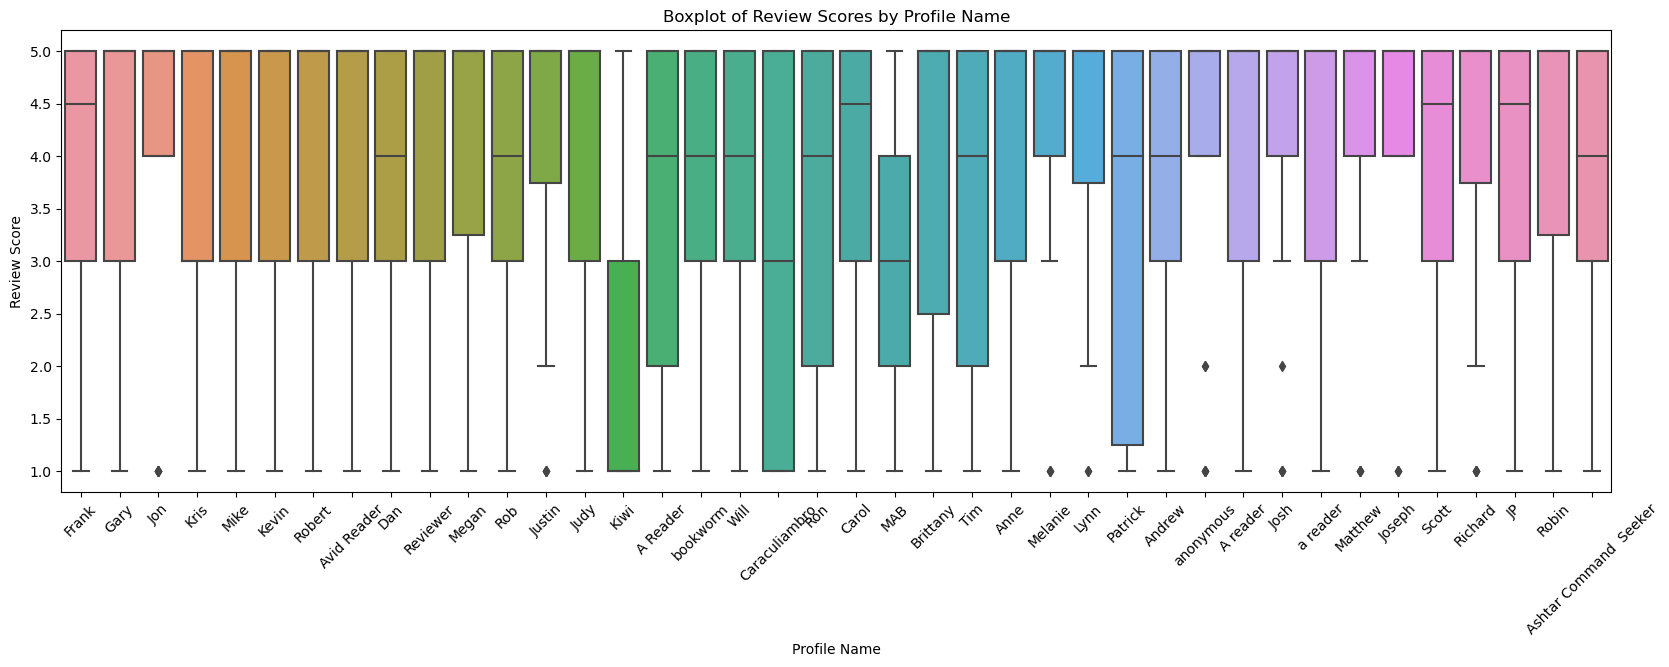

In [82]:
subsample_stat = user_stats.head(40)
df_to_show = source_df.merge(subsample_stat, on='profileName', how='inner')
df_to_show = df_to_show[['profileName', 'review/score']]

# Create a boxplot
plt.figure(figsize=(20, 6))
sns.boxplot(x='profileName', y='review/score', data=df_to_show)
plt.title('Boxplot of Review Scores by Profile Name')
plt.ylabel('Review Score')
plt.xlabel('Profile Name')
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Perform one-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.  
The groups are the profileNames.  
Results of the test :
- F-statistic (F-statistic):
  The F-statistic is a test statistic generated by the ANOVA test. It measures the ratio of the variation between group means to the variation within the groups.
  A larger F-statistic indicates a greater difference in means among the groups relative to the variation within the groups.
  In the context of ANOVA, a larger F-statistic is more likely to lead to the rejection of the null hypothesis, suggesting that there are significant differences among the groups.

  
- P-value (p_value):
  The p-value is a measure of the evidence against the null hypothesis (H0) in statistical hypothesis testing.
  It represents the probability of observing the results (or more extreme results) if the null hypothesis were true.
  In the context of ANOVA, a small p-value (typically less than your chosen significance level, e.g., 0.05) suggests that the differences in means among the groups are statistically significant.
  Conversely, a large p-value suggests that the observed differences could have occurred by random chance, and you fail to reject the null hypothesis.

In [83]:
subset_df = source_df.merge(subsample_stat, on='profileName', how='inner')
subset_df = subset_df[['profileName', 'review/score']]

# Group scores by user
user_groups = [subset_df['review/score'][subset_df['profileName'] == user]
               for user in subset_df['profileName'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*user_groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 2.057606176383496
P-value: 0.00015189235334697715


---


### Now let's analyze if the anonymous users give lower rating score
The hypotheses **H0** and **H1** are the same as before, but there are only two groups: *Anonymous* and *Known*  

In [88]:
source_df['profileName'] = source_df['profileName'].apply(
    lambda x: 'Known' if x != 'Anonymous' else x)

In [85]:
user_stats = source_df.groupby('profileName').mean()


user_stats['Std_review_score'] = source_df.groupby('profileName').std()
user_stats.reset_index(inplace=True)
user_stats.columns = ['profileName',
                      'Mean_review/score', 'Std_review_score']

user_stats

,profileName,Mean_review/score,Std_review_score
0,Anonymous,4.149833,1.310514
1,Known,4.225834,1.180680


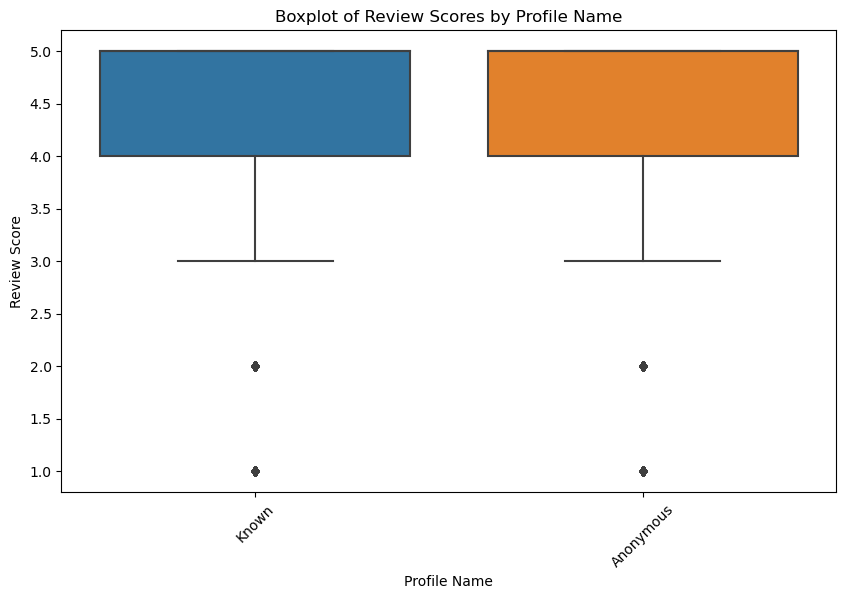

In [86]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='profileName', y='review/score', data=source_df)
plt.title('Boxplot of Review Scores by Profile Name')
plt.ylabel('Review Score')
plt.xlabel('Profile Name')
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [87]:

# Example data (replace with your datasets)
data_user1 = source_df[source_df['profileName']
                       == 'Anonymous']['review/score'].to_list()
data_user2 = source_df[source_df['profileName']
                       != 'Known']['review/score'].to_list()

# Perform KS test
sa.scipy_analize(data_user1, 'Anonymous', data_user2, 'Known', [3])

The p-value for Kolmogorov-Smirnov test between Anonymous and Known is 1.0. The two variables follow the same distribution.


###  Conclusion
The ANOVA F-statistic, which is notably high, coupled with an extremely low p-value, leads us to reject the null hypothesis (H0). Consequently, we can conclude that the rating score is significantly influenced by the user. Different users tend to provide significantly different rating scores for books.  

Contrary to the initial assumption, our findings indicate that anonymous users are not more critical in their book ratings. This is supported by a low Kolmogorov-Smirnov p-value, suggesting that the distribution of ratings for anonymous users does not significantly differ from that of non-anonymous users. Thus, we find no evidence to suggest that anonymous users underrate books compared to non-anonymous users.
